# Mutual Information-based Registration

## Introduction
In this exercise, you will implement 3D rigid image registration using mutual information (MI). You will work with a T1-weighted and a T2-weighted MRI scan of the same patient, where the patient is lying in a different position in the scanner between the two image acquisition (for the purpose of this exercise, the movement is simulated).

### Instructions for your report
Your report should be structured as follows:
* **Introduction**: a short summary of what your report is about, perhaps with a recap of some of the equations you'll be using in your solution.
* **Task 1, ..., 5**: for each specific task listed below, your code (in code cells), your results (as figures) as well as explanations of what is computed and what is shown in the figures (in Markdown cells). 
* **Conclusion**: a short summary of your findings.

This introduction should **not** be part of your report.

### Input data and code hints
Import Python libraries:

In [11]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook
# %matplotlib tk
plt.ion()
np.set_printoptions( suppress=True )
import nibabel as nib
import scipy
from scipy.ndimage import map_coordinates

Read the two 3D scans you'll be working with in this exercise:

In [12]:
T1_fileName = '/Users/xixiwang/Desktop/DTUcoures/MIA-main/exercises/ex3/IXI014-HH-1236-T1.nii'
T2_fileName = '/Users/xixiwang/Desktop/DTUcoures/MIA-main/exercises/ex3/IXI014-HH-1236-T2_rotated.nii'
T1 = nib.load( T1_fileName )
T2 = nib.load( T2_fileName )
T1_data = T1.get_fdata()
T2_data = T2.get_fdata()

Below is code to define a simple interactive viewer class that can be used to visualize 2D cross-sections of a 3D array along three orthogonal directions. It takes a 3D volume as input and shows the location a "linked cursor" in all three cross-sections.

The initial location of the cursor is in the middle of the volume in each case. It can be changed by clicking on one of the cross-sections. The viewer also displays the voxel index $\mathbf{v}$ of the cursor.

In [13]:
class Viewer:
    def __init__(self, data ):
        self.fig, self.ax = plt.subplots()
        self.data = data
        self.dims = self.data.shape
        self.position = np.round( np.array( self.dims ) / 2 ).astype( int )
        self.draw()
        self.fig.canvas.mpl_connect( 'button_press_event', self )
        self.fig.show()

    def __call__(self, event):
        print( 'button pressed' )
        if event.inaxes is None: return
      
        x, y = round( event.xdata ), round( event.ydata )

        #
        if ( x > (self.dims[0]-1) ) and ( y <= (self.dims[1]-1) ): return # lower-right quadrant
          
        #
        if x < self.dims[0]:
          self.position[ 0 ] = x
        else:
          self.position[ 1 ] = x - self.dims[0]
        
        if y < self.dims[1]:
          self.position[ 1 ] = y
        else:
          self.position[ 2 ] = y -self.dims[1]
        
        print( f"  voxel index: {self.position}" )
        print( f"  intensity: {self.data[ self.position[0], self.position[1], self.position[2] ]}" )

        self.draw()

    def draw( self ):
        #
        # Layout on screen is like this:
        #
        #     ^            ^
        #  Z  |         Z  |
        #     |            |
        #     ----->        ---->  
        #       X             Y
        #     ^
        #  Y  |
        #     |
        #     ----->  
        #       X
        #
        dims = self.dims
        position = self.position
        
        xySlice = self.data[ :, :, position[ 2 ] ]
        xzSlice = self.data[ :, position[ 1 ], : ]
        yzSlice = self.data[ position[ 0 ], :, : ]
        
        kwargs = dict( vmin=self.data.min(), vmax=self.data.max(), 
                       origin='lower', 
                       cmap='gray',
                       picker=True )

        self.ax.clear()

        self.ax.imshow( xySlice.T, 
                        extent=( 0, dims[0]-1, 
                                 0, dims[1]-1 ), 
                        **kwargs )
        self.ax.imshow( xzSlice.T, 
                        extent=( 0, dims[0]-1, 
                                 dims[1], dims[1]+dims[2]-1 ), 
                        **kwargs )
        self.ax.imshow( yzSlice.T, extent=( dims[0], dims[0]+dims[1]-1, 
                                            dims[1], dims[1]+dims[2]-1 ), 
                        **kwargs )

        color = 'g'
        self.ax.plot( (0, dims[0]-1), (position[1], position[1]), color )
        self.ax.plot( (0, dims[0]+dims[1]-1), (dims[1]+position[2], dims[1]+position[2]), color )
        self.ax.plot( (position[0], position[0]), (0, dims[1]+dims[2]-1), color )
        self.ax.plot( (dims[0]+position[1], dims[0]+position[1]), (dims[1]+1, dims[1]+dims[2]-1), color )

        self.ax.set( xlim=(1, dims[0]+dims[1]), ylim=(0, dims[1]+dims[2]) )

        self.ax.text( dims[0] + dims[1]/2, dims[1]/2, 
                      f"voxel index: {position}",  
                      horizontalalignment='center', verticalalignment='center' )
  
        self.ax.axis( False )

        self.fig.canvas.draw()

### Task 1: Resample the T2-weighted scan to the image grid of the T1-weighted scan

In this task you perform the resampling just like in the landmark-based registration exercise. Find the voxel-to-voxel transformation between $\mathbf{v}_{T1}$ and $\mathbf{v}_{T2}$:

$$
\begin{pmatrix} \mathbf{ v_{T2}} \\ 1 \end{pmatrix} = \mathbf{M}_{T2}^{-1} \cdot \mathbf{M}_{T1} \cdot \begin{pmatrix} \mathbf{ v_{T1}} \\ 1 \end{pmatrix}
.
$$
At the location $\mathbf{v}_{T2}$, you should then use cubic B-spline interpolation to determine the intensity in the T2-weighted scan, and store it at index $\mathbf{v}_{T1}$ in the newly created image.

> ***Hints:***
> - you can create a coordinate grid in 3D with the function
> 
>        V1,V2,V3 = np.meshgrid( np.arange( T1_data.shape[0] ), 
>                                np.arange( T1_data.shape[1] ), 
>                                np.arange( T1_data.shape[2] ), indexing='ij' )
>   
>
> - the following SciPy function interpolates the T2-weighted volume at voxel coordinates $(1.1,2.2,3.3)^T$ 
> and $(6.6,7.7,8.8)^T$ using cubic interpolation:   
>
>        scipy.ndimage.map_coordinates( T2_data, np.array( [ [1.1,2.2,3.3], [6.6,7.7,8.8] ] ).T )

In [14]:
V1,V2,V3 = np.meshgrid( np.arange( T1_data.shape[0] ),  np.arange( T1_data.shape[1] ),  np.arange( T1_data.shape[2] ), indexing='ij' )
M_T1 = T1.affine
M_T2 = T2.affine  # 4x4 matrix for T2-weighted image

# Inverse of the T2 affine matrix
M_T2_inv = np.linalg.inv(M_T2)

# Stack the voxel coordinates into a 4xN array (homogeneous coordinates)
voxel_coords_T1 = np.vstack((V1.ravel(), V2.ravel(), V3.ravel(), np.ones(V1.size)))

# Transform the coordinates from the T1 to the T2 space
voxel_coords_T2 = np.dot(M_T2_inv, np.dot(M_T1, voxel_coords_T1))

# Extract the 3D voxel coordinates in the T2-weighted space
v_T2_1 = voxel_coords_T2[0, :]
v_T2_2 = voxel_coords_T2[1, :]
v_T2_3 = voxel_coords_T2[2, :]
T2_data_resampled = scipy.ndimage.map_coordinates(T2_data, [v_T2_1, v_T2_2, v_T2_3], order=3).reshape(T1_data.shape)


Once you have created the resampled T2-weighted data, visualize the T1-weighted and resampled T2-weighted volumes overlaid as follows:
    
        Viewer( T2_data_resampled / T2_data_resampled.max() + T1_data / T1_data.max() )

 Can you determine around what axis (in world coordinates) the rotation was simulated?

 > ***Hint***
 > - The T2-weighted volume was rotated around a single axis only.
 >

/var/folders/89/n7z9_hx13xg6jcy_80f9yj900000gn/T/ipykernel_5449/1359666277.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


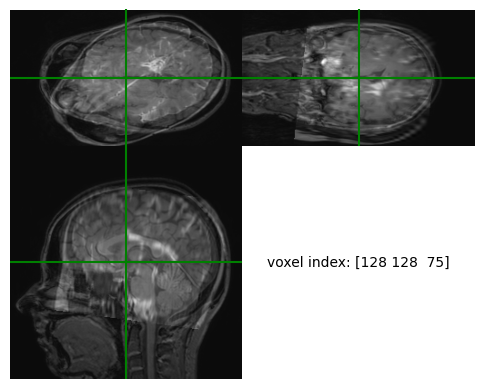

In [15]:
Viewer(T2_data_resampled / T2_data_resampled.max() + T1_data / T1_data.max())


y

### Task 2: Compute and visualize the joint histogram

Compute the joint histogram 
$$ 
\mathbf{H} = 
\begin{pmatrix}
h_{1,1} & ... & h_{1,B} \\
\vdots & ... & \vdots \\
h_{B,1} & ... & h_{B,B} \\
\end{pmatrix} 
$$
of the T1-weighted scan and the resampled T2-weighted scan you just created, using $B=32$ bins. In order not to let the registration process be dominated by the (extremely numerous) background voxels, ignore all voxels with an intensity lower than 10 in either image when computing the histogram. Visualize the joint histogram using a 3D bar plot, and label the axes.

> ***Hints:***
>
> - To compute a 2D histogram, you can use the function
>
>           np.histogram2d(x,y,bins,range)
> 
> - A 3D bar plot can be created as follows:
>
>           fig, ax = plt.subplots( subplot_kw=dict( projection='3d') )
>           plt.bar3d(xpos, ypos, zpos, dx, dy, dz)
>
>   where xpos, ypos, and zpos are the anchor points of the bars and dx, dy, and dz are the dimensions of the bars.
>
> - A useful "trick" to verify that your axes are labeled correctly, is to use a different number of bins for the two scans.
>

In [16]:
mask = (T1_data >= 10) & (T2_data_resampled >= 10)
H, xedges, yedges=np.histogram2d(T1_data[mask].ravel(),T2_data_resampled[mask].ravel(),32)
print(xedges.shape)


(33,)


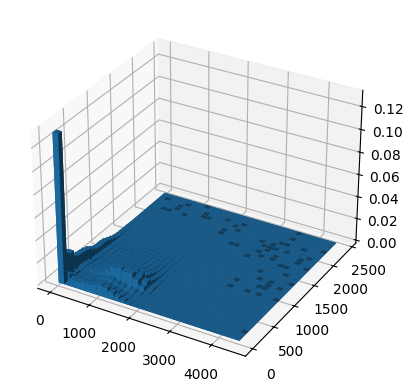

In [17]:

fig, ax = plt.subplots( subplot_kw=dict( projection='3d') )
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)  # Start bars at z=0

# Size of the bars
dx =  (xedges[1] - xedges[0])  # Width of each bar
dy =  (yedges[1] - yedges[0]) 
H=H/np.sum(H) 
dz = H.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz)

### Task 3: Compute the mutual information between the two images
Write a function that takes two image volumes defined on the same image grid as input, and returns the mutual information between the two images:

$$ 
MI = H_{F} + H_{M} - H_{F,M} 
$$
with
$$ 
H_{F,M} = - \sum_{f=1}^{B} \sum_{m=1}^{B} p_{f,m} \log(p_{f,m}),
$$
$$ 
H_{F} = - \sum_{f=1}^{B} p_{f} \log(p_{f}), 
$$
and
$$
H_{M} = - \sum_{m=1}^{B} p_{m} \log(p_{m})
.
$$

Your function should make use of the joint histogram computed as in the previous task (i.e., using $B=32$ bins and ignoring all voxels with intensity lower than 10).

Use your new function to compute the mutual information between the T1-weighted image and the resampled T2-weighted image.

> ***Hints:***
>
> - To avoid numerical errors when one of the bins is empty and 0*log(0)=0 is therefore computed numerically, you can add a tiny value (e.g., 1e-12) to each histogram bin

In [18]:
def claH(h):
    h=h/np.sum(h)
    h=h+1e-12
    return -np.sum(h/np.sum(h)*np.log(h))

H_m,_=np.histogram(T2_data_resampled[mask].ravel(),32)
H_f,_=np.histogram(T1_data[mask].ravel(),32)
H_FM=claH(H)
H_M=claH(H_m)
H_F=claH(H_f)
M=H_F+H_M-H_FM
print(M)

0.11674744542198301


### Task 4: Evaluate the mutual information across a range of rotation angles

Implement a grid search over a range of rotation angles, with the goal of identifying the angle with approximately the highest mutual information (i.e., where the registration is best). Make an educated guess of a suitable range by visually inspecting the images (or by simply trying a few rotation angles and inspecting the result), and then define a list of candidate angles at intervals of e.g., 5° apart:

       a = np.arange(a_{lowest}, a_{highest}, 5)

Loop over all candidate rotation angles, each time (1) creating a corresponding rotation matrix $\mathbf{R}$; (2) resampling the T2-weighted volume accordingly; (3) calculating the mutual information with the function you created above; and (4) storing the mutual information value.

> ***Hint:***
> 
> - A 3D rotation matrix can be parameterized as follows:
> 
> $$\mathbf{R} = \mathbf{R}_{z} \mathbf{R}_{y} \mathbf{R_{x}},$$ 
> where
>
> $$
\mathbf{R}_z = 
\begin{pmatrix} 
 cos( \theta_z ) & -sin( \theta_z ) & 0 & \\
 sin( \theta_z ) & cos( \theta_z ) & 0 & \\
 0 & 0 & 1 & \\
\end{pmatrix}
$$
> implements a rotation around the z-axis in world coordinates;
> $$
\mathbf{R}_y = 
\begin{pmatrix} 
 cos( \theta_y ) & -sin( \theta_y ) & 0 & \\
 0 & 1 & 0 & \\
 sin( \theta_y ) & cos( \theta_y ) & 0 & \\
\end{pmatrix}
$$
> is a rotation around the y-axis;
and
> $$
\mathbf{R}_x = 
\begin{pmatrix} 
 1 & 0 & 0 & \\
 cos( \theta_x ) & -sin( \theta_x ) & 0 & \\
 sin( \theta_x ) & cos( \theta_x ) & 0 & \\
\end{pmatrix}
$$
> rotates around the x-axis.
>
>
> - If you didn't figure out in Task 1 which axis the T2-weighted volume was rotated around, you can try rotating around each axis (one at a time) to see the effect of each transformation. Once you've determined the correct rotation axis, the rotation angles around the other axes should be clamped to zero.


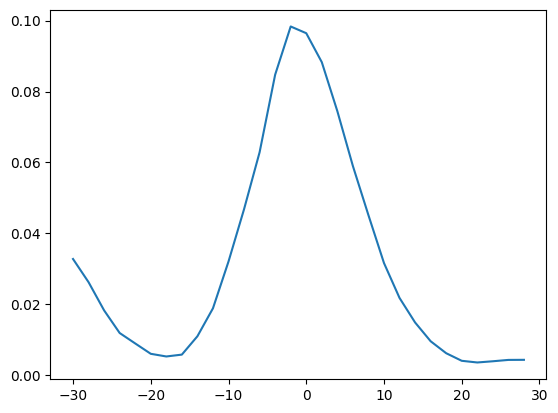

In [25]:
def CalMutualInformation(data1,data2):
    mask = (data1 >= 10) & (data2>= 10)
    b=16
    H, _,_=np.histogram2d(data1[mask].ravel(),data2[mask].ravel(),b)
    H_m,_=np.histogram(data2[mask].ravel(),b)
    H_f,_=np.histogram(data1[mask].ravel(),b)
    H_FM=claH(H)
    H_M=claH(H_m)
    H_F=claH(H_f)
    M=H_F+H_M-H_FM
    return M

A= np.arange(-30, 30, 2)
M_angle=[]
Energy={}
for a in A: 
    # a=0
    a=a*3.1415926/180
    a_x=0
    a_z=a
    Ry=np.array([[np.cos(a),0,np.sin(a)],[0,1,0],[-np.sin(a),0,np.cos(a)]])
    
    # Rz=np.array([[np.cos(a_z),-np.sin(a_z),0],[np.sin(a_z),np.cos(a_z),0],[0,0,1]])
    
    # Rx=np.array([[1,0,0],[np.cos(a_x),-np.sin(a_x),0],[np.sin(a_x),np.cos(a_x),0]])
    # R=Rz@Ry@Rx
    
    
    T2_resampled = scipy.ndimage.affine_transform(T2_data_resampled,Ry)
    M=CalMutualInformation(T1_data,T2_resampled)
    M_angle.append(M)
    Energy[a]=-M
    

    
plt.plot(A,M_angle)
# plt.plot(A,Energy)

plt.show()

### Task 5: Perform automatic registration

Plot the negative mutual information, i.e. the energy function $E(\mathbf{w})= H_{F,M}-H_{F}-H_{M}$ for every angle in your grid search space. Select the one with the lowest energy (i.e., the best angle for registration) and transform the T2-weighted volume according to this angle.

Use the Viewer() function to visualize your registration result.

/var/folders/89/n7z9_hx13xg6jcy_80f9yj900000gn/T/ipykernel_5449/1359666277.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


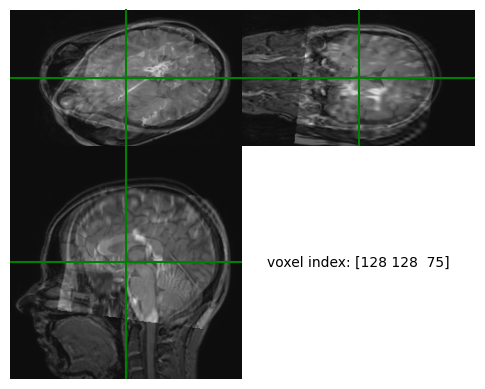

In [26]:
min_key = min(Energy, key=Energy.get)
a=min_key
Ry=np.array([[np.cos(a),0,np.sin(a)],[0,1,0],[-np.sin(a),0,np.cos(a)]])
T2_resampled = scipy.ndimage.affine_transform(T2_data_resampled,Ry)
Viewer(T2_resampled / T2_resampled.max() + T1_data / T1_data.max())

### Task 6: Compare the joint histogram before and after registration

Visualize the joint histogram after registration. Compare the result to your initial joint histogram (i.e., before registration) and discuss your findings in your report.

(33,)


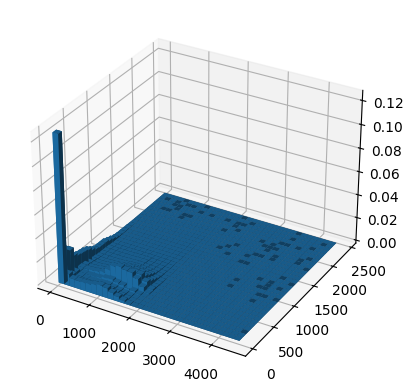

In [28]:
mask = (T1_data >= 10) & (T2_resampled >= 10)
H, xedges, yedges=np.histogram2d(T1_data[mask].ravel(),T2_resampled[mask].ravel(),32)
print(xedges.shape)

fig, ax = plt.subplots( subplot_kw=dict( projection='3d') )
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)  # Start bars at z=0

# Size of the bars
dx =  (xedges[1] - xedges[0])  # Width of each bar
dy =  (yedges[1] - yedges[0]) 
H=H/np.sum(H) 
dz = H.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz)

### Additional task for the enthusiastic student: Compare the MI obtained with landmark-based and intensity-based registration

Perform landmark-based registration between the T1-weighted and T2-weighted volumes instead, just like you did in the last exercise. For the resulting registration, view your results with the Viewer() class; visualize the joint histogram, and calculate the mutual information. 

Compare the results with those obtained using mutual information, and discuss.

> ***Hint:***
> - You can reuse the landmarks that you collected in the landmark-based registration exercise, as these were defined in voxel space. 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 